In [1]:
import numpy as np
import variational_bayes as vb
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def simulate(n, m, population_precision=1):
    x = np.random.normal(0, 1, n) / np.sqrt(population_precision)
    y = np.random.normal(0, 1, (m, n)) + x[None, :]
    return x, y

x, y = simulate(10, 10)

In [3]:
def hierarchical_model(y):
    factors = {
        'x': vb.NormalDistribution(np.zeros(y.shape[1]), np.ones(y.shape[1])),
        'precision': vb.GammaDistribution(1, 1)
    }
    likelihoods = [
        vb.NormalDistribution(0, factors['precision']).likelihood(factors['x']),
        vb.NormalDistribution(factors['x'], 1).likelihood(y)
    ]
    model = vb.Model(factors, likelihoods)
    model.update(10)
    return model


def naive_model(y):
    factors = {
        'x': vb.NormalDistribution(np.zeros(y.shape[1]), np.ones(y.shape[1])),
    }
    likelihoods = [
        vb.NormalDistribution(factors['x'], 1).likelihood(y)
    ]
    model = vb.Model(factors, likelihoods)
    model.update(1)
    return model

In [4]:
population_precisions = np.logspace(-3, 3, 21)
num_runs = 10
num_items = 100
num_obs = 100

naive_rmses = []
hierarchical_rmses = []

for population_precision in population_precisions:
    naive_rmse = []
    hierarchical_rmse = []
    for _ in range(num_runs):
        x, y = simulate(num_items, num_obs, population_precision * num_obs)
        model = naive_model(y)
        naive_rmse.append(np.sqrt(np.mean(np.square(model['x'].mean - x))))
        model = hierarchical_model(y)
        hierarchical_rmse.append(np.sqrt(np.mean(np.square(model['x'].mean - x))))
        
    naive_rmses.append(naive_rmse)
    hierarchical_rmses.append(hierarchical_rmse)

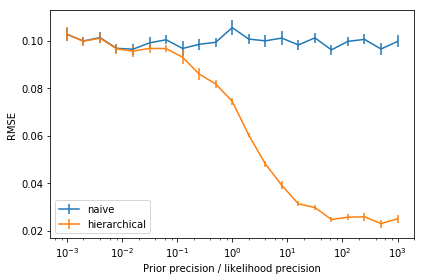

In [5]:
plt.errorbar(population_precisions, np.mean(naive_rmses, axis=1), vb.std_mean(naive_rmses, axis=1),
             label='naive')
plt.errorbar(population_precisions, np.mean(hierarchical_rmses, axis=1), vb.std_mean(hierarchical_rmses, axis=1),
             label='hierarchical')
plt.xscale('log')
plt.ylabel('RMSE')
plt.xlabel('Prior precision / likelihood precision')
plt.legend()
plt.tight_layout()